# Letter image recognition

![pic](https://imgur.com/qBl14zL.png)

Download

[Kaggle Dataset](https://www.kaggle.com/c/street-view-getting-started-with-julia/data)

## Data Preprocessing

### Image Color
Almost all images in training and test data sets are color images. The first step in preprocessing is to convert all the images to grayscale. It simplifies the data that is entered into the network and also allows the model to be more generalized, since a blue letter and a red letter are the same for the classification of this image. Therefore, this preprocessing to reduce the channel of the image color should have no negative effect on the final accuracy, as most of the text is highly contrasting with the background.

### Image Resizing
Since the images have different shapes and sizes, we have to normalize the images so that we can determine the model's input. There are two major issues that need to be addressed in this process: Which image size do we choose? Should we keep the image aspect ratio?

At first, I also thought it would be better to keep the aspect ratio of the image as it would not distort the image. This can also lead to confusion between O and O (uppercase o and zero). However, after some testing, it seems that the model does not maintain the aspect ratio better.

With respect to image size, a 16 × 16 image allows very fast training but does not give the best results. These small images are the perfect choice for quick test ideas. The use of 32 × 32 images makes training quick and provides good accuracy. Finally, the use of a 64x64 image made the training considerably slower and slightly improved than the 32x32 image. I chose to use 32 × 32 images because it is the best compromise between speed and accuracy.

In [20]:
import os
import glob
import pandas as pd
import math
import numpy as np
import cv2
from IPython.display import Image

path = "D:/Program/dataset/First Steps With Julia"

# The target size after image conversion
img_height, img_width = 32, 32

# Save the directory after converting the image
suffix = "Preproc"
trainDataPath = path + "/train" + suffix
testDataPath = path + "/test" + suffix

# create directory
if not os.path.exists(trainDataPath):
    os.makedirs(trainDataPath)

if not os.path.exists(testDataPath):
    os.makedirs(testDataPath)
    
trainDataPath

'D:/Program/dataset/First Steps With Julia/trainPreproc'

In [32]:
%%time
### Image size and image color preprocessing ###

for datasetType in ["train","test"]:
    # ordered the datapath, use "key=os.path.getmtime"
    imgFiles = sorted(glob.glob(path + "/" + datasetType + "/*.bmp"), key=os.path.getmtime)
    imgData = np.zeros((len(imgFiles), img_height, img_width))
    
    for i, imgFilePath in enumerate(imgFiles):
        # Image Color processing, to gray scale
        img_gray = cv2.imread(imgFilePath,0)        
        imgResized = cv2.resize(img_gray, (img_height, img_width))
        imgData[i] = imgResized
        
        # get the basename, ex: 1.Bmp or 6284.Bmp
        filename = os.path.basename(imgFilePath)
        filenameDotSplit = filename.split(".")
        
        # zfill, ex: 00001.bmp or 06284.bmp
        newFilename = filenameDotSplit[0].zfill(5) + "." + filenameDotSplit[-1].lower()
        newFilepath = path + "/" + datasetType + suffix + "/" + newFilename
        cv2.imwrite(newFilepath, imgResized)

    # add the dimension of "Channel"
    print("Before: ", imgData.shape)
    imgData = imgData[:,:,:,np.newaxis] 
    print("After: ", imgData.shape)
    
    # Data standardization
    imgData = imgData.astype('float32')/255
    
    # Save the image converted ndarray object as a numpy object to the file system
    np.save(path + "/" + datasetType + suffix + ".npy", imgData)
        

Before:  (6283, 32, 32)
After:  (6283, 32, 32, 1)
Before:  (6220, 32, 32)
After:  (6220, 32, 32, 1)
Wall time: 1min 46s


## Label Conversion
We also have to convert one-hot encoding of the character's label. It is necessary to provide tag information to the CNN neural network. This process consists of two steps. First, we convert characters to consecutive integers. Since the characters to be predicted are [0 ~ 9], [a ~ z] and [A ~ Z] are 62 characters in total, we will assign each character to an integer from [0 to 61].



In [10]:
import keras

def label2int(ch):
    # Given a string representing one Unicode character, 
    # return an integer representing the Unicode code point of that character. 
    asciiVal = ord(ch)
    if(asciiVal<=57): #0-9
        asciiVal-=48
    elif(asciiVal<=90): #A-Z
        asciiVal-=55
    else: #a-z
        asciiVal-=61
    return asciiVal
    
def int2label(i):
    if(i<=9): #0-9
        i+=48
    elif(i<=35): #A-Z
        i+=55
    else: #a-z
        i+=61
    return chr(i)

In [38]:
# Only keep "label information" column
y_train = pd.read_csv(path + "/trainLabels.csv").values[:,1] 
y_train

array(['n', '8', 'T', ..., 'P', 'N', 'R'], dtype=object)

In [40]:
# One-hot encoding for the label

# A-Z, a-z, 0-9, there are 62 categories
Y_train = np.zeros((y_train.shape[0], 62)) 

for i in range(y_train.shape[0]):
    Y_train[i][label2int(y_train[i])] = 1 # One-hot

# The converted label (Label) data stored in the file system for subsequent rapid loading and processing
np.save(path + "/" + "labelsPreproc.npy", Y_train)

## Data Augmentation

Use ImageDataGenerator

[documentation](https://keras.io/preprocessing/image/#imagedatagenerator)

* `featurewise_center` , `featurewise_std_normalization` and `zca_whitening` are not used as they don’t increase the performance of the network. If you want to test these options, be sure to compute the relevant quantities with fit and apply these modifications to your test set with standardize .

* `rotation_range` Best results for values around 20.
* `width_shift_range` Best results for values around 0.15.
* `height_shift_range` Best results for values around 0.15.
* `shear_range` Best results for values around 0.4.
* `zoom_range` Best results for values around 0.3.
* `channel_shift_range` Best results for values around 0.1.

## Learning

Used a categorical cross-entropy loss function, as the final layer uses a softmax activation.

## Algorithm

Instead of using a classic but often slow stochastic gradient descent (SGD) algorithm, I chose to use AdaMax and AdaDelta. I found that AdaMax tends to give better results than AdaDelta for this problem. However, for complex networks with numerous filters and large fully-connected layers, AdaMax struggles to converge for the first epochs or even fails completely to converge. For my network, I use a few epochs (~20) of AdaDelta before using AdaMax. It is not necessary to use this strategy if you divided by 2 or more the size of the network.

## Layer Initialization

The optimization algorithm can fail to find an optimum if the network is not properly initialized. I found that using the initialization presented by he_normal made the learning much easier. In Keras, you just have to use the `init='he_normal'` parameter for each layer.



In [2]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

batch_size = 128 
nb_classes = 62  # A-Z, a-z, 0-962 categories
nb_epoch = 300   

# Input image dimensions
img_height, img_width = 32, 32

# Path of data files
path = "D:/Program/dataset/First Steps With Julia"

# Load the preprocessed data and labels
X_train_all = np.load(path+"/trainPreproc.npy")
Y_train_all = np.load(path+"/labelsPreproc.npy")

In [5]:
X_train_all.shape

(6283, 32, 32, 1)

In [6]:
# Split in train and validation sets to get the "best" model.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=0.25, 
                                                  stratify=np.argmax(Y_train_all, axis=1))

# Parametrize the image augmentation class
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.4,
    zoom_range = 0.3,                    
    channel_shift_range = 0.1)

In [7]:
### CNN MODEL ###

model = Sequential()

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu', 
                        input_shape=(img_height, img_width, 1)))

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, kernel_initializer='he_normal', activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 512)         1180160   
__________

In [8]:
### LEARNING ###

# First, use AdaDelta for some epochs because AdaMax gets stuck
model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta',  
              metrics=["accuracy"])

# 20 epochs is sufficient
model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=20, 
                    validation_data=(X_val, Y_val),
                    verbose=1)

# Now, use AdaMax
model.compile(loss='categorical_crossentropy', 
              optimizer='adamax',  
              metrics=["accuracy"])


# We want to keep the best model. This callback will store 
# in a file the weights of the model with the highest validation accuracy 
saveBestModel = ModelCheckpoint("best.kerasModelWeights", monitor='val_acc', verbose=1, 
                                save_best_only=True, save_weights_only=True)

# Make the model learn using the image generator
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=nb_epoch, 
                    validation_data=(X_val, Y_val),
                    callbacks=[saveBestModel],
                    verbose=1)

Train on 4712 samples, validate on 1571 samples
Epoch 1/20
4712/4712 [==============================] - 27s 6ms/step - loss: 3.9836 - acc: 0.0548 - val_loss: 3.8243 - val_acc: 0.0732
Epoch 2/20
4712/4712 [==============================] - 18s 4ms/step - loss: 3.8162 - acc: 0.0698 - val_loss: 3.7588 - val_acc: 0.0936
Epoch 3/20
4712/4712 [==============================] - 18s 4ms/step - loss: 3.7968 - acc: 0.0798 - val_loss: 3.7845 - val_acc: 0.0732
Epoch 4/20
4712/4712 [==============================] - 18s 4ms/step - loss: 3.6834 - acc: 0.1216 - val_loss: 3.6866 - val_acc: 0.0853
Epoch 5/20
4712/4712 [==============================] - 18s 4ms/step - loss: 3.1315 - acc: 0.2430 - val_loss: 2.5696 - val_acc: 0.3558
Epoch 6/20
4712/4712 [==============================] - 18s 4ms/step - loss: 2.4032 - acc: 0.3941 - val_loss: 1.9629 - val_acc: 0.4672
Epoch 7/20
4712/4712 [==============================] - 18s 4ms/step - loss: 1.8686 - acc: 0.5104 - val_loss: 1.7111 - val_acc: 0.5716
Epoch 8

Epoch 21/300
37/36 [==============================] - 16s 442ms/step - loss: 0.8093 - acc: 0.7594 - val_loss: 0.6848 - val_acc: 0.8008
Epoch 22/300
37/36 [==============================] - 17s 465ms/step - loss: 0.7703 - acc: 0.7567 - val_loss: 0.6903 - val_acc: 0.8103
Epoch 23/300
37/36 [==============================] - 17s 466ms/step - loss: 0.7617 - acc: 0.7714 - val_loss: 0.6400 - val_acc: 0.8160
Epoch 24/300
37/36 [==============================] - 16s 442ms/step - loss: 0.7640 - acc: 0.7619 - val_loss: 0.6606 - val_acc: 0.7950
Epoch 25/300
37/36 [==============================] - 16s 443ms/step - loss: 0.7225 - acc: 0.7764 - val_loss: 0.6409 - val_acc: 0.8129
Epoch 26/300
37/36 [==============================] - 17s 465ms/step - loss: 0.7102 - acc: 0.7822 - val_loss: 0.6317 - val_acc: 0.8173
Epoch 27/300
37/36 [==============================] - 16s 443ms/step - loss: 0.6845 - acc: 0.7834 - val_loss: 0.6617 - val_acc: 0.8071
Epoch 28/300
37/36 [==============================] - 1

37/36 [==============================] - 16s 432ms/step - loss: 0.4755 - acc: 0.8467 - val_loss: 0.6496 - val_acc: 0.8141
Epoch 53/300
37/36 [==============================] - 16s 431ms/step - loss: 0.4786 - acc: 0.8370 - val_loss: 0.6595 - val_acc: 0.8243
Epoch 54/300
37/36 [==============================] - 16s 438ms/step - loss: 0.4303 - acc: 0.8549 - val_loss: 0.6450 - val_acc: 0.8230
Epoch 55/300
37/36 [==============================] - 16s 433ms/step - loss: 0.4640 - acc: 0.8498 - val_loss: 0.6623 - val_acc: 0.8167
Epoch 56/300
37/36 [==============================] - 16s 433ms/step - loss: 0.4397 - acc: 0.8572 - val_loss: 0.7107 - val_acc: 0.8148
Epoch 57/300
37/36 [==============================] - 16s 431ms/step - loss: 0.4149 - acc: 0.8618 - val_loss: 0.6615 - val_acc: 0.8250
Epoch 58/300
37/36 [==============================] - 16s 434ms/step - loss: 0.4246 - acc: 0.8596 - val_loss: 0.6598 - val_acc: 0.8008
Epoch 59/300
37/36 [==============================] - 16s 432ms/step

37/36 [==============================] - 16s 432ms/step - loss: 0.3375 - acc: 0.8819 - val_loss: 0.7003 - val_acc: 0.8288
Epoch 85/300
37/36 [==============================] - 16s 434ms/step - loss: 0.3239 - acc: 0.8885 - val_loss: 0.7122 - val_acc: 0.8250
Epoch 86/300
37/36 [==============================] - 16s 433ms/step - loss: 0.3045 - acc: 0.8913 - val_loss: 0.7069 - val_acc: 0.8218
Epoch 87/300
37/36 [==============================] - 16s 434ms/step - loss: 0.3063 - acc: 0.9007 - val_loss: 0.6628 - val_acc: 0.8313
Epoch 88/300
37/36 [==============================] - 16s 434ms/step - loss: 0.3125 - acc: 0.8930 - val_loss: 0.7454 - val_acc: 0.8243
Epoch 89/300
37/36 [==============================] - 16s 438ms/step - loss: 0.3286 - acc: 0.8935 - val_loss: 0.6832 - val_acc: 0.8288
Epoch 90/300
37/36 [==============================] - 16s 437ms/step - loss: 0.2995 - acc: 0.9029 - val_loss: 0.6666 - val_acc: 0.8250
Epoch 91/300
37/36 [==============================] - 17s 462ms/step

Epoch 117/300
37/36 [==============================] - 16s 431ms/step - loss: 0.2491 - acc: 0.9124 - val_loss: 0.7203 - val_acc: 0.8402
Epoch 118/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2556 - acc: 0.9121 - val_loss: 0.7519 - val_acc: 0.8307
Epoch 119/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2489 - acc: 0.9131 - val_loss: 0.7310 - val_acc: 0.8377
Epoch 120/300
37/36 [==============================] - 16s 432ms/step - loss: 0.2364 - acc: 0.9193 - val_loss: 0.6965 - val_acc: 0.8320
Epoch 121/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2126 - acc: 0.9317 - val_loss: 0.7336 - val_acc: 0.8339
Epoch 122/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2558 - acc: 0.9161 - val_loss: 0.7774 - val_acc: 0.8250
Epoch 123/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2402 - acc: 0.9177 - val_loss: 0.7520 - val_acc: 0.8383
Epoch 124/300
37/36 [===========================

37/36 [==============================] - 16s 432ms/step - loss: 0.2028 - acc: 0.9301 - val_loss: 0.7109 - val_acc: 0.8332
Epoch 150/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1914 - acc: 0.9375 - val_loss: 0.7165 - val_acc: 0.8351
Epoch 151/300
37/36 [==============================] - 16s 432ms/step - loss: 0.1941 - acc: 0.9321 - val_loss: 0.7531 - val_acc: 0.8281
Epoch 152/300
37/36 [==============================] - 16s 432ms/step - loss: 0.2020 - acc: 0.9287 - val_loss: 0.7656 - val_acc: 0.8307
Epoch 153/300
37/36 [==============================] - 16s 432ms/step - loss: 0.1963 - acc: 0.9364 - val_loss: 0.7701 - val_acc: 0.8307
Epoch 154/300
37/36 [==============================] - 16s 432ms/step - loss: 0.2265 - acc: 0.9282 - val_loss: 0.7657 - val_acc: 0.8307
Epoch 155/300
37/36 [==============================] - 16s 433ms/step - loss: 0.2008 - acc: 0.9298 - val_loss: 0.7540 - val_acc: 0.8281
Epoch 156/300
37/36 [==============================] - 16s 433

Epoch 182/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1671 - acc: 0.9468 - val_loss: 0.8132 - val_acc: 0.8434
Epoch 183/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1514 - acc: 0.9453 - val_loss: 0.8102 - val_acc: 0.8402
Epoch 184/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1992 - acc: 0.9357 - val_loss: 0.7498 - val_acc: 0.8332
Epoch 185/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1649 - acc: 0.9414 - val_loss: 0.7878 - val_acc: 0.8339
Epoch 186/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1618 - acc: 0.9430 - val_loss: 0.8528 - val_acc: 0.8383
Epoch 187/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1749 - acc: 0.9398 - val_loss: 0.8602 - val_acc: 0.8377
Epoch 188/300
37/36 [==============================] - 16s 432ms/step - loss: 0.1719 - acc: 0.9401 - val_loss: 0.8244 - val_acc: 0.8390
Epoch 189/300
37/36 [===========================

Epoch 215/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1499 - acc: 0.9512 - val_loss: 0.8823 - val_acc: 0.8351
Epoch 216/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1679 - acc: 0.9474 - val_loss: 0.8194 - val_acc: 0.8345
Epoch 217/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1392 - acc: 0.9541 - val_loss: 0.9238 - val_acc: 0.8345
Epoch 218/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1677 - acc: 0.9413 - val_loss: 0.8986 - val_acc: 0.8307
Epoch 219/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1508 - acc: 0.9558 - val_loss: 0.8157 - val_acc: 0.8434
Epoch 220/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1486 - acc: 0.9485 - val_loss: 0.8976 - val_acc: 0.8332
Epoch 221/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1567 - acc: 0.9506 - val_loss: 0.9400 - val_acc: 0.8402
Epoch 222/300
37/36 [===========================

Epoch 248/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1393 - acc: 0.9549 - val_loss: 0.8559 - val_acc: 0.8402
Epoch 249/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1391 - acc: 0.9513 - val_loss: 0.8283 - val_acc: 0.8370
Epoch 250/300
37/36 [==============================] - 16s 434ms/step - loss: 0.1230 - acc: 0.9588 - val_loss: 0.8387 - val_acc: 0.8351
Epoch 251/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1245 - acc: 0.9606 - val_loss: 0.8629 - val_acc: 0.8351
Epoch 252/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1424 - acc: 0.9533 - val_loss: 0.8067 - val_acc: 0.8383
Epoch 253/300
37/36 [==============================] - 16s 434ms/step - loss: 0.1292 - acc: 0.9549 - val_loss: 0.8301 - val_acc: 0.8421
Epoch 254/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1278 - acc: 0.9591 - val_loss: 0.8657 - val_acc: 0.8396
Epoch 255/300
37/36 [===========================

Epoch 281/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1156 - acc: 0.9630 - val_loss: 0.9373 - val_acc: 0.8332
Epoch 282/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1257 - acc: 0.9610 - val_loss: 0.9265 - val_acc: 0.8269
Epoch 283/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1273 - acc: 0.9568 - val_loss: 0.8390 - val_acc: 0.8300
Epoch 284/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1115 - acc: 0.9629 - val_loss: 0.9445 - val_acc: 0.8370
Epoch 285/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1326 - acc: 0.9597 - val_loss: 0.9265 - val_acc: 0.8326
Epoch 286/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1202 - acc: 0.9601 - val_loss: 0.9023 - val_acc: 0.8364
Epoch 287/300
37/36 [==============================] - 16s 433ms/step - loss: 0.1393 - acc: 0.9581 - val_loss: 0.8401 - val_acc: 0.8313
Epoch 288/300
37/36 [===========================

In [11]:
### PREDICTION ###

# Load the model with the highest validation accuracy
model.load_weights("best.kerasModelWeights")

# Load Kaggle test set
X_test = np.load(path+"/testPreproc.npy")

# Predict the class (give the index in the one-hot vector of the most probable class)
Y_test_pred = model.predict_classes(X_test)

# Translate integers to character labels
vInt2label = np.vectorize(int2label)
Y_test_pred = vInt2label(Y_test_pred) 

# Save the predicitions in Kaggle format
np.savetxt(path+"/jular_pred" + ".csv", np.c_[range(6284,len(Y_test_pred)+6284),Y_test_pred], 
           delimiter=',', header = 'ID,Class', comments = '', fmt='%s')

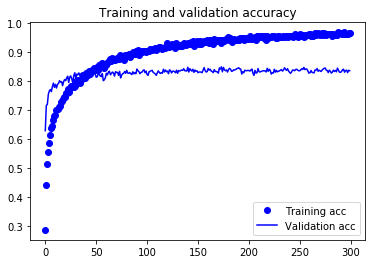

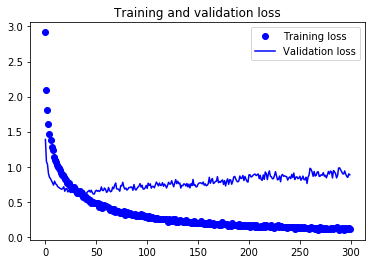

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# ACC
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# LOSS
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Summary

Two-phase model training ideas and optimizer (adadelta and adamax) are different with other example

The CNN does few mistakes a human wouldn’t do, so there is little room for improvement without overfitting to the dataset. The main source of errors is confusions between:

* lower and capital letters
* 1, l and I (one, lower L and capital i)
* 0 and O (zero and capital o)
* Letters rotated by 90 and other letters